# Improved model for unperturbed hydrogen atom

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate

In [2]:
def effective_PE(r,n,l,QD):
    """This function is the effective_potential part of the differential equation 
    which can be solved to obtain the radial wave equation for a hydrogen atom 
    r is the radius
    n is the principle quantum number
    l is the orbital angular momentum quantum number
    QD is the quantum defect"""
    if r==0: # when radius is 0 from the center nuclear, the probability wavefunction for electron is 0.
        return 0
    else: 
        centrifugal_PE=-l*(l+1)/(r*r) 
        #potential energy due to the centrifugal force
        coulomb_PE=-1/r 
        orbital_energy=-1/((n-QD)*(n-QD))
        #energy of the energy level
        return centrifugal_PE-2*coulomb_PE+orbital_energy

In [3]:
def SBS_method(fun,N,h,n,l,QD):
    """Step by step method can find the result of second order differential equation
    fun is the potential function of an atom
    N is the total number of the points
    h is the interval between two neibouring points
    n is the principle quantum number
    l is the orbital angular momentum quantum number
    QD is the quantum defect"""
    TOTAL_X= N*h #the furtherest distance between the electron and the nuclear
    x = np.linspace(0,TOTAL_X,N+1) # each radial point on the x direction
    retval = np.zeros((N+1)) 
    eff_PE= np.zeros((N+1))
    retval[0] = 0 # boundary condition: when r=0, the probability of the electron is 0.
    retval[1] = 0.1 # boundary condition
    r=0 # start with radius is equal to 0
    for i in range(1,N):
        r+= h
        eff_PE[i]=fun(r,n,l,QD) # find the potential part of the radial wavefunction
    for j in range(1,N):
        retval[j+1]=((2-10*h*h*eff_PE[j]/12)*retval[j]- (1+h*h*eff_PE[j-1]/12)*retval[j-1])/( 1+h*h*eff_PE[j+1]/12)
    return x,retval

In [4]:
def REV_SBS_method(fun,N,h,n,l,QD):
    """Step by step method can find the result of second order differential equation
    fun is the potential function of an atom
    N is the total number of the points
    h is the interval between two neibouring points
    n is the principle quantum number
    l is the orbital angular momentum quantum number
    QD is the quantum defect
    R is a large value where the wavefunction terminates"""
    TOTAL_X= N*h #the furtherest distance between the electron and the nuclear
    x = np.linspace(TOTAL_X,0,N+1) # each radial point on the x direction
    retval = np.zeros((N+1)) 
    eff_PE = np.zeros((N+1))
    retval[0] = 0 # boundary condition: when r=0, the probability of the electron is 0.
    retval[1] = 0.1 # boundary condition
    r=TOTAL_X # start with radius is equal to R
    for i in range(1,N):
        r-= h
        eff_PE[i]=fun(r,n,l,QD) # find the potential part of the radial wavefunction
    for j in range(1,N):
        retval[j+1]=((2-10*h*h*eff_PE[j]/12)*retval[j]- (1+h*h*eff_PE[j-1]/12)*retval[j-1])/( 1+h*h*eff_PE[j+1]/12)
    return x,retval

In [5]:
def plot(x,y,title,n,l):
    """Plot the wavefunction"""
    plt.plot(x,y,label="P{0:.0f},{1:.0f}".format(n,l))
    # the plot that contains a label which has two variables.
    #they are n principal quantum number, l orbital angular momentum number
    plt.xlabel('radius r/a0')
    plt.ylabel('wavefunction Pnl')
    plt.title(title)
    plt.grid()

In [6]:
def NM_radial_wavefunction(fun,N,h,n,l,QD,show_plot):
    """The normallised radial wavefunction of atoms and plot the graph
    fun is the potential function of an atom
    N is the total number of points
    h is the interval between two neibouring points
    n is the principal quantum number
    l is the orbital angular momentum quantum number
    QD is the quantum defect
    R is a large value where the wavefunction terminates """
    #apply boundary condition to wavefunction by using step by step method 
    wave=SBS_method(fun,N,h,n,l,QD)
    wave2=REV_SBS_method(fun,N,h,n,l,QD) #reversed step by step method
    
    #normallised first derivative of both functions
    diff_wave = (np.roll(wave[1],-1) - np.roll(wave[1],1))/(2*h) # first derivative of the wave function
    NM_diff_wave=diff_wave[1:N]/wave[1][1:N] # Normallise the first derivative of the wave function to get rid of the constant

    REV_wave2=(wave2[1][::-1]) # reversed wave function 2
    REV_diff_wave2 = (np.roll(REV_wave2,-1) - np.roll(REV_wave2,1))/(2*h)# reversed first derivative of the wave function 2
    REV_NM_diff_wave2=REV_diff_wave2[1:N]/REV_wave2[1:N] # normallised and reversed first derivative of the wave function
    
    #Find the continuity for the first derivative of both wavefunction
    continuity=NM_diff_wave-REV_NM_diff_wave2 # the first term has division by 0, so it is excluded in calculation
    
    # the minimum value after subtraction is the first order derivative continuous point
    mini_value=np.min(abs(continuity))
    intersection=np.where(abs(continuity)==mini_value)

    if len(intersection)>0 and len(intersection[0])>0:
        POI=intersection[0][0] #point of intersection

    wave3=np.concatenate([wave[1][0:POI+1],REV_wave2[POI+1:N+1]])# two parts are continuous in shape
    # we have found that the intersection point is when N=19+1=20, because the first term of the 'continuity' array was removed.
    
    #make two parts of the wavefunctions continuous
    constant1=wave[1][POI]/REV_wave2[POI]
    REV_wave2_constant1=REV_wave2*constant1
    UN_Pnl=np.concatenate([wave[1][0:POI+1],REV_wave2_constant1[POI+1:N+1]])# unnormallised wavefunction
    
    #normallising the wavefunction after combining two continuous parts
    UN_Pnl_square=UN_Pnl*UN_Pnl
    constant2_squared=integrate.simps(UN_Pnl_square,wave[0])
    constant2=np.sqrt(constant2_squared)
    Pnl=UN_Pnl/constant2 
    #final numerical solution of the normallised radial wave function
    if show_plot==True:
        plot(wave[0],Pnl,'Normalised radial wavefunction in the 1s orbital of a sodium atom',n,l)
        return Pnl
    if show_plot==False:
        return Pnl

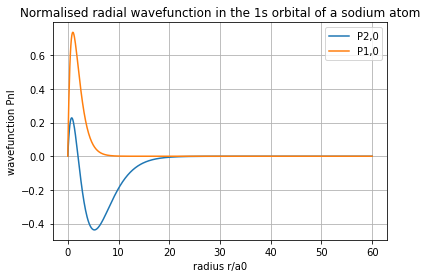

In [7]:
Pnl1= NM_radial_wavefunction(effective_PE,600,0.1,2,0,0,True)
Pnl2= NM_radial_wavefunction(effective_PE,600,0.1,1,0,0,True)
plt.grid()
plt.legend()


# Radiative transitions in an unperturbed hydrogen atom

This is a study of the oscillator strength for hydrogen atoms. Oscillator strength is a dimensionless quantity which is the frequency difference between two energy levels that one electron is allowed to be transited. The focus of this project is to compute and investigate the strongest transitions which arise from the dipole interaction in one atom. The following equation defines the oscillator strength:


$f(nl\rightarrow n'l')=\frac{2}{3}(E_{n'l'}-E_{nl})C_{l'}\mid\int_0^\infty P_{nl}(r)rP_{n'l'}(r)\,dr \mid^{2} $

where $ C_{l'}=\frac{max(l,l')}{2l+1}$,  $E_{n'l'}>E_{nl}$, $l'=l+1$

and both $E_{n'l'}$and$E_{nl}$ are in atomic units,$E_{nl}=-\frac{1}{2n^{*2}}$; $E_{n'l'}=-\frac{1}{2n'^{*2}}$

Firstly, find the term $\int_0^\infty P_{nl}(r)rP_{n'l'}(r)\,dr $, which is the integration from origin to positive infinity of radial wavefunctions and position operator r with respect to radius r. Since the numerical solution of $P_{nl}$ has been found as above, the numerical value of $\int_0^\infty P_{nl}(r)rP_{n'l'}(r)\,dr $ thus can be determined. 
To simplfy the issue, the transition of an electron from 1S orbital to 2P orbital will be studied.

The radial wavefunction of a hydrogen atom at 1S orbital is defined as follows:

$P(1s)=2re^{-r}$

The radial wavefunction of a hydrogen atom at 2P orbital is defined as follows:

$P(2p)=\frac{1}{2\sqrt{6}}r^{2}e^{-\frac{r}{2}}$

In [8]:
def analytic_P1s(r):
    """The analytical solution of the radial wavefunction in 1S orbital"""
    return 2*r*np.exp(-r)
def analytic_P2p(r):
    """The analytical solution of the radial wavefunction in 2P orbital"""
    return 1/(2*np.sqrt(6))*r*r*np.exp(-r/2)

In [9]:
def analytical_integral(fun,N,h,n,l,QD):
    """Having looked up the analytical solutions of the radial wavefunctions at 
    different energy level and different orbitals, analytical solutions can be 
    calculated by integrating "PrP_prime" from origin to infinity"""
    wave=SBS_method(fun,N,h,n,l,QD) #wave[0] provides the x axis for the later integration use
    P1s = np.zeros((N+1))
    P2p = np.zeros((N+1))
    r=0 # starting point is 0
    P1s[0]=0 # wavefunction of 1s is equal to 0 at the origin 
    P2p[0]=0 # wavefunction of 2p is equal to 0 at the origin
    for i in range(1,N):
        r+=h
        P1s[i]=analytic_P1s(r)
        P2p[i]=analytic_P2p(r)
    matrix_element=P1s*P2p*wave[0] 
    # matrix element which is comprised of the product of r and radial wave function in two energy states
    integral=integrate.simps(matrix_element,wave[0]) 
    #integrating the matrix element
    plot(wave[0],P1s,'Normalised Radial wave equation of a hydrogen atom ',n,l)
    plot(wave[0],P2p,'Normalised Radial wave equation of a hydrogen atom ',2,1)
    plt.legend()
    plt.grid()
    return integral

1.2902661492759353

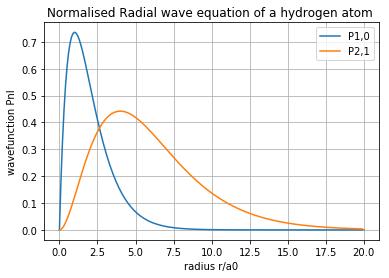

In [10]:
analytical_integral(effective_PE,200,0.1,1,0,0)

In [11]:
def numerical_integral(fun,N,h,n,l,QD,n_prime,l_prime,QD_prime,show_plot):
    """This is a function which integrate "PrP_prime" from origin to 
    infinity to obtain a numerial result, where "PrP" stands for the 
    product of two radial wavefunctions and position operator r  
    fun is the potential function of an atom
    N is the total number of the points
    h is the interval between two neibouring points
    n is the principle quantum number in the initial level
    l is the orbital angular momentum quantum number in the initial level
    QD is the quantum defect in the initial level
    n_prime is the principle quantum number in the transited level
    l_prime is the orbital angular momentum quantum number in the transited level
    QD_prime is the quantum defect in the transited level
    R is a large value where the wavefunction terminates """
    wave=SBS_method(fun,N,h,n,l,QD) 
    #wave[0] provides the x axis for the later integration use
    
    RW=NM_radial_wavefunction(fun,N,h,n,l,QD,show_plot)
    # the radial wavefunction of the electron in the initial level
    RW_prime=NM_radial_wavefunction(fun,N,h,n_prime,l_prime,QD_prime,show_plot)  
    # the radial wavefunction of the electron in the transited level
    matrix_element=RW*wave[0]*RW_prime 
    # the product of two radial wavefunctions and r
    integral=integrate.simps(matrix_element,wave[0]) 
    # the integration from origin to positive infinity of PrP_prime

    return integral

In [12]:
numerical_integral(effective_PE,200,0.1,1,0,0,2,1,0,False)

1.2920077948550936

After that, compare the obtainde value with the value calculated from analytical value.

Finally, The calculated numerical solutions can be used to find the oscillation strength.

In [13]:
def Energy_diff(n,QD,n_prime,QD_prime):
    """This function finds the energy shift between two levels 
    where an electron has transfered """
    Energy=-1/(2*(n-QD)*(n-QD)) 
    # energy of the electron at the initial level 
    Energy_prime=-1/(2*(n_prime-QD_prime)*(n_prime-QD_prime)) 
    # energy of the electron at the transited level 
    return Energy_prime-Energy

In [14]:
def Cl_prime(l,l_prime):
    """A constant which has orbital angular momentum quantum number dependency 
    in the function "Oscillator_strength" """
    max_val=np.max([l,l_prime]) 
    # find the larger value between the orbital angular momentum quantum numbers 
    # which are before and after transition
    return max_val/(2*l+1)

In [ ]:
def oscillator_strength(fun,N,h,n,l,QD,n_prime,l_prime,QD_prime):
    """This is a funciton which find the oscillator strength of a hydrogen atom 
    while the strong transition occurs
    N is the total number of points
    h is the interval between two neighbouring points
    n is the principal quantum number in the initial level
    l is the orbital angular momentum quantum number in the initial level
    QD is the quantum defect in the initial level
    n_prime is the principal quantum number in the transited level
    l_prime is the orbital angular momentum quantum number in the transited level
    QD_prime is the quantum defect in the transited level
    R is a large value where the wave function terminates """
    integral_squared=numerical_integral(fun,N,h,n,l,QD,n_prime,l_prime,QD_prime,False)**2
    strength=(2/3)*Energy_diff(n,QD,n_prime,QD_prime)*Cl_prime(l,l_prime)*integral_squared 
    # Oscillator strength is a measure of frequency
    return strength

## Unperturbed oscillator strength in a hydrogen atom

In [ ]:
os2p1s=oscillator_strength(effective_PE,200,0.1,2,1,0,1,0,0)
os1s2p=oscillator_strength(effective_PE,200,0.1,1,0,0,2,1,0)
os11p10s=oscillator_strength(effective_PE,4000,0.1,11,1,0,10,0,0)
os10s11p=oscillator_strength(effective_PE,4000,0.1,10,0,0,11,1,0)
print(os2p1s,os1s2p,os11p10s,os10s11p)

In [ ]:
os=np.zeros((4,10)) 
#data of unperturbed oscillator strength in a hydrogen atom
for ni in range(1,5):# ni is the initial n
    for nf in range (1,10): # nf is the final n
        os[ni-1,nf]=oscillator_strength(effective_PE,5000,0.1,nf+1,2,0,ni,1,0)  
print(os)

## life time of atomic hydrogen and Einstein coefficients


In [ ]:
def Lyman_series(n):
    """function for lyman series which have an electron transfering from a high energy level
    to the ground state by emitting a photon"""
    series=np.zeros(n-2)
    for i in range(2,n):
        series[i-2]=oscillator_strength(effective_PE,1000,0.1,i,1,0,1,0,0)
    return series

In [ ]:
abs(Lyman_series(10))

#### Transition rate for spontaneous emission in terms of oscillator strength is defined as follows:

$W^{s}_{ka}=\frac{2\hbar\alpha(\omega_{ka})^{2}}{mc^{2}}|f_{ka}| $

Where, $\omega$ is the angular frequency, $\omega_{ka}=(E_{k}-E_{a})/\hbar=\frac{3}{8}\frac{mc^{2}}{\hbar}(Z\alpha)^{2}$

In [ ]:
def tran_rate_spon_emiss(fun,N,h,n,l,QD,n_prime,l_prime,QD_prime):
    """transitoin rate for spontaneous emission of a hydrogen atom"""
    
    #constants in SI units
    
    m_e=9.109*10**(-31)
    #mass of an electron (kg)
    h_bar=6.62607015*10**(-34)/(2*np.pi)
    #planck constant/2π
    permittivity=8.8541878176*10**(-12)
    #permittivity of vacuum (F/m)
    e=1.602176634*10**(-19)
    #charge of an electron in coulomb (c)
    c=299792458 
    #speed of light (m/s)
    FINE_STR=e**2/(4*np.pi*permittivity*h_bar*c)
    #Fine structure constant
    omega_square=((3*m_e*(c**2)*(FINE_STR)**2)/(8*h_bar))**2
    #diference between angular frequency and squared
    
    absolute_os=abs(oscillator_strength(fun,N,h,n,l,QD,n_prime,l_prime,QD_prime))
    
    w=(2*h_bar*FINE_STR*omega_square)*absolute_os/(m_e*(c**2))
    # transition rate
    return w

In [ ]:
spon_emiss_2p1s=tran_rate_spon_emiss(effective_PE,2000,0.1,2,1,0,1,0,0)
print(spon_emiss_2p1s)

#### Lifetime of atomic hydrogen 

$\tau=\frac{1}{\sum W(nl\rightarrow n'l')}$

In [ ]:
tau=1/spon_emiss_2p1s
print(tau)

#### Einstein Coefficients

$A_{21}=F(\omega)B_{21}=W^{s}_{21}$

Where $F(\omega)=\frac{\hbar\omega_{12}^{3}}{\pi^{2}c^{3}}, \omega$ is the angular frequency, $\omega_{ka}=(E_{k}-E_{a})/\hbar=\frac{3}{8}\frac{mc^{2}}{\hbar}(Z\alpha)^{2}$

$B_{21}=\frac{A_{21}}{F(\omega)}=\frac{A_{21}\pi^{2}c^{3}}{\hbar\omega_{12}^{3}}$

Where $g_{1}=\frac{1}{g_{2}}$



$B_{12}=\frac{g1}{g2}B_{21}$



In [ ]:
def Einstein_Coefficients(fun,N,h,n,l,QD,n_prime,l_prime,QD_prime,EC_type):
    
    #constants in SI units
    m_e=9.109*10**(-31)
    #mass of an electron (kg)
    h_bar=6.62607015*10**(-34)/(2*np.pi)
    #planck constant/2π
    permittivity=8.8541878176*10**(-12)
    #permittivity of vacuum (F/m)
    e=1.602176634*10**(-19)
    #charge of an electron in coulomb (c)
    c=299792458 
    #speed of light (m/s)
    FINE_STR=e**2/(4*np.pi*permittivity*h_bar*c)
    #Fine structure constant
    omega_cubed=((3*m_e*(c**2)*(FINE_STR)**2)/(8*h_bar))**3
    
    A_21=tran_rate_spon_emiss(fun,N,h,n,l,QD,n_prime,l_prime,QD_prime)
    if EC_type=="EC_A_21":# spontaneous emission
        return A_21
    else:              # stimulated emission or absorption
        F_omega=(h_bar*omega_cubed)/(((np.pi)**2)*c**3)
        #equilibrium radiation energy density
        B_21=A_21/F_omega
        if EC_type=="EC_B_21":
            return B_21,F_omega
            # stimulated emission
        else:
            B_12=(2*l+1)*B_21
            return B_12
            # stimulated absorption

In [ ]:
Einstein_Coefficients(effective_PE,2000,0.1,3,0,0,2,1,0,"EC_A_21")

In [ ]:
A=np.zeros((4,10)) 
#data of unperturbed oscillator strength in a hydrogen atom
for ni in range(1,5):# ni is the initial n
    for nf in range (1,10): # nf is the final n
        A[ni-1,nf]=Einstein_Coefficients(effective_PE,2000,0.1,nf+1,2,0,ni,1,0,"EC_A_21")
print(A)

# The influence of a week magnetic field in a hydrogen atom

 This part of the project focuses on the perturbation of a weak external magnetic field. The assumption that has made was to neglect the spin part of the wavefunction, so that spin orbit coupling would not occur. The total angular momentum quantum number J is the sum of orbital angular momentum quantum number L and spin quantum number S. In this special case, J is equivalent to L.


The following oscillator strength equation is an update version with the addition of the magnetic quantum number m :


$
\begin{align}
&f(nlm\rightarrow n'l'm')\\
&=\frac{2}{3}(E_{n'l'm'}-E_{nlm})\mid\int_0^\infty P_{nl}(r)Y_{lm}^{*}(θ,ϕ)(\frac{4π }{3})^{\frac{1}{2}}rY_{1μ}(θ,ϕ)P_{n'l'}(r)Y_{l'm'}(θ,ϕ)\sin(θ)dr dθdϕ \mid^{2} \\
\end{align}
$

where  $E_{n'l'm'}>E_{nlm}$, $l'=l+1$, $m=-l,…0,…l$， m is the magnetic quantum number, P is the radial wave function, Y is the angular part of the wave function.


Extracting the angular part of the integral out:

$
\begin{align}
I & = \int_0^\infty Y_{lm}^{*}(θ,ϕ)(\frac{4π }{3})^{\frac{1}{2}}Y_{1μ}(θ,ϕ)Y_{l'm'}(θ,ϕ)sin(θ)\,dθdϕ \\
 & = [(2l+1)(2l'+1)]^{\frac{1}{2}}(-1)^{m}\begin{pmatrix} l&1&l'\\0&0&0 \end{pmatrix}\quad\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad\\
\end{align}
$

$
\begin{align}
\begin{pmatrix} l&1&l'\\0&0&0 \end{pmatrix}\quad\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad\\
\end{align}
$
are not matrices but algebraic coefficients that can be evaluated using the following relations:


$
\begin{align}
\begin{pmatrix} J+1&J&1\\M&-M-1&1 \end{pmatrix}\quad& =(-1)^{J-M-1}{[\frac{(J-M)(J-M+1)}{(2J+3)(2J+2)(2J+1)}]}^{\frac{1}{2}},\\
\begin{pmatrix} J+1&J&1\\M&-M&0 \end{pmatrix}\quad& =(-1)^{J-M-1}{[\frac{(J+M+1)(J-M+1)×2}{(2J+3)(2J+2)(2J+1)}]}^{\frac{1}{2}},\\
\begin{pmatrix} j1&j2&j3\\m1&m2&m3 \end{pmatrix}\quad& =(-1)^{j1+j2+j3}\begin{pmatrix} j1&j2&j3\\-m1&-m2&-m3 \end{pmatrix}\quad,\\
\begin{pmatrix} j1&j2&j3\\0&0&0 \end{pmatrix}\quad& =0,\>if\> J\> is\> odd\> where\> J=j1+j2+j3,\\
\begin{pmatrix} j1&j2&j3\\m1&m2&m3 \end{pmatrix}\quad& =0,\> unless\>\> m1+m2+m3=0\\
\end{align}
$

$\mid mi\mid\le j_{i};i=1,2,3$

The following equations are two cases for 
$
\begin{align}
\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad:\\
\end{align}
$

##### 1.When μ=0; l=l; l’=l+1; m=m; m’=m+μ=m,

$
\begin{align}
\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad&=\begin{pmatrix} l&1&l+1\\-m&0&m \end{pmatrix}\quad\\
&= \begin{pmatrix} l+1&l&1\\m&-m&0 \end{pmatrix}\quad\\
&=(-1)^{l-m-1}{[\frac{(l+m+1)(l-m+1)×2}{(2l+3)(2l+2)(2l+1)}]}^{\frac{1}{2}}\\
\end{align}
$

##### 2.When μ=1, J=l, M=m-1

$
\begin{align}
\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad
&=\begin{pmatrix} l&1&l+1\\-m&1&m-1 \end{pmatrix}\quad\\
&=\begin{pmatrix} l+1&l&1\\m-1&-m&1 \end{pmatrix}\quad\\
&=(-1)^{l-(m-1)-1}{[\frac{(l-(m-1))(l-(m-1)+1)}{(2l+3)(2l+2)(2l+1)}]}^{\frac{1}{2}}\\
\end{align}
$


In [ ]:
def vc_coefficient_l(l,m,l_prime,m_prime,mu):
    """A function calculating Vector-Coupling coefficient"""
    if l_prime==l+1:
        M1=m-1
        if mu==0:
            phase_constant0=(-1)**(l-m_prime-1)
            sqrt_term0= np.sqrt((l+m_prime+1)*(l-m_prime+1)*2/((2*l+3)*(2*l+2)*(2*l+1)))
            return phase_constant0*sqrt_term0
        else:
            phase_constant=(-1)**(l-M1)
            sqrt_term= np.sqrt((l-M1)*(l-M1+1)/((2*l+3)*(2*l+2)*(2*l+1)))
            return phase_constant*sqrt_term
    else:
        L1=l-1
        M2=-m
        if mu==0:
            phase_constant0=(-1)**(L1-M2-1)
            sqrt_term0= np.sqrt((L1+M2+1)*(L1-M2+1)*2/((2*L1+3)*(2*L1+2)*(2*L1+1)))
            return phase_constant0*sqrt_term0
        else:
            phase_constant=(-1)**(L1-M2)
            sqrt_term= np.sqrt((L1-M2)*(L1-M2+1)/((2*L1+3)*(2*L1+2)*(2*L1+1)))
            return phase_constant*sqrt_term     

### Zero external magnetic field

For the case of zero external magnetic field, the oscillator strength will only have n and l dependence as defined as follows:


$
\begin{align}
f(nl\rightarrow n'l')=\frac{1}{2l+1}\sum_{mm'\mu}f(nlm\rightarrow n'l'm')\\
\end{align}
$

Where we have summed over final states m’ and averaged over initial states m. Moreover, the different components of the vector r was summed over as well. Since there are (2l+1) degenerate m states, the total sum of the oscillator strength with variable (nlm) was divided by its weight (2l+1).


In what follows, it is the general analysis of the term Clwhich has appeared in (11).

$
\begin{align}
\frac{1}{2l+1}\sum_{mm'\mu}I^{2} & =(2l'+1){\begin{pmatrix} l&1&l'\\0&0&0 \end{pmatrix}\quad}^{2}\sum_{mm'\mu}{\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad}^{2}\\
& =(2l'+1){\begin{pmatrix} l&1&l'\\0&0&0 \end{pmatrix}\quad}^{2}\\
& =C_{l}\\
\end{align}
$

where $l'=l\pm1$


### Weak external magnetic field
Eternal Zeeman effect occurs while applying a weak magnetic field upon an atom. The reason that a strong magnetic field is not applied is due to the fact that the wide split of energy levels inside of an atom can break it apart.
Now, if a magnetic field is applied, the energies of the perturbed states are given by:

$ E_{nlm}=E_{nl}+μ_{e}B_{m} $		

Where μe is the Bohr magneton[1], it is defined as follows:

$
\begin{align}
μe&=\frac{eh}{2m_{e}}\\
&=9.2740094910-24JT^{-1}\\
&=2.1271912131510-6E_{H}T^{-1} \\
\end{align}
$

$E_{H}$is a unit of energy in atomic units, and $E_{H}$=4.3597441710-18J



Rewrite equation of oscillator strength with variable nlm in terms of angular and radial part separately:

$
\begin{align}
&f(nlm\rightarrow n'l'm')\\
&=\frac{2}{3}[E_{n'l'}-E_{nl}+\mu_{e}B×(m'-m)]\mid\int_0^\infty P_{nl}(r)rP_{n'l'}(r)dr \mid^{2} \\
&×(2l+1)(2l'+1){[\begin{pmatrix} l&1&l'\\0&0&0 \end{pmatrix}\quad\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad]}^{2}
\end{align}
$

B is the field in units of T (Tesla) and so from (25) (26), μeBm can be expressed in atomic units of energy.


With the relations of the algebraic coefficients (16), (17), (18) and (20), the perturbed oscillator strengths are related to the field free ones simply through algebraic coefficients and field B.


$
\begin{align}
&f(nlm\rightarrow n'l'm')\\
&=[1+\frac{\mu_{e}B×(m'-m)}{E_{n'l'}-E_{nl}}]{\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad}^{2}(2l+1) f(nl\rightarrow n'l') \\
\end{align}
$

In [ ]:
#transition_data=n,l,m,QD,n_prime,l_prime,m_prime,QD_prime
def os_magnetic_1(fun,N,h,data,B):
    """orifinal version of oscillator strength in a weak magnetic field
    in terms of unperturbed oscillator strength.
    The spin part of the wave function is assumed to be negligible, thus L=J."""
    mu=data[-2]-data[2]
    # difference between m' 1and m.
    vc_coefficient_squared=(vc_coefficient_l(data[1],data[2],data[5],data[6],mu))**2
    #vc_coefficient(l,m,l_prime,m_prime,mu)
    unperturbed_os=oscillator_strength(fun,N,h,data[0],data[1],data[3],data[4],data[5],data[7])
    
    mu_e=(9.27400949/4.35974417)*10**(-6)
    energy_coefficient=1+(mu_e*B*mu)/Energy_diff(data[0],data[3],data[4],data[-1])
    #Energy_diff(n,QD,n_prime,QD_prime)
    perturbed_os=(2*data[1]+1)*energy_coefficient*vc_coefficient_squared*unperturbed_os
    return perturbed_os

$
\begin{align}
&f(nlm\rightarrow n'l'm')\\
&=\frac{2}{3}[{E_{n'l'}-E_{nl}+\mu_{e}B×(m'-m)}]{\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad}^{2}(2l+1) C_{l'}\mid\int_0^\infty P_{nl}(r)rP_{n'l'}(r)\,dr \mid^{2} \\
\end{align}
$

where $ C_{l'}=\frac{max(l,l')}{2l+1}$,  $E_{n'l'}>E_{nl}$, $l'=l+1$

and both $E_{n'l'}$and$E_{nl}$ are in atomic units,$E_{nl}=-\frac{1}{2n^{*2}}$; $E_{n'l'}=-\frac{1}{2n'^{*2}}$

In [ ]:
def os_magnetic_2(fun,N,h,data,B):
    """The second version of oscillator strength in a weak magnetic field
    in terms of transition dipole moment.
    The spin part of the wave function is assumed to be negligible, thus L=J."""
    mu=data[-2]-data[2]
    # difference between m' 1and m
    
    vc_coefficient_squared=(vc_coefficient_l(data[1],data[2],data[5],data[6],mu))**2
    #vc_coefficient(l,m,l_prime,m_prime,mu)
    
    integral_squared=numerical_integral(fun,N,h,data[0],data[1],data[3],data[4],data[5],data[7],False)**2
    # numerical_integral(fun,N,h,n,l,QD,n_prime,l_prime,QD_prime,False)
    
    mu_e=(9.27400949/4.35974417)*10**(-6)
    energy_coefficient=Energy_diff(data[0],data[3],data[4],data[-1])+mu_e*B*mu
    
    perturbed_os=(2/3)*(2*data[1]+1)*energy_coefficient*Cl_prime(data[1],data[5])*integral_squared*vc_coefficient_squared 
    # Cl_prime(l,l_prime)=Cl_prime(data[1],data[5])
    # Oscillator strength is a measure of frequency
    return perturbed_os,vc_coefficient_squared

In [ ]:
#transition_data_mag=n,l,m,QD,n_prime,l_prime,m_prime,QD_prime
transition_data_mag=3,1,0,0,2,0,0,0 
#a=os_magnetic_1(effective_PE,2000,0.1,transition_data_mag,1)
b=os_magnetic_2(effective_PE,2000,0.1,transition_data_mag,1)
print(b)

In [ ]:
osm=np.zeros((3)) 
#data of unperturbed oscillator strength in a hydrogen atom
for nf in range(1,4):# ni is the initial n
    #for nf in range (1,4): # nf is the final n
    #print(nf)
    transition_data=1,0,0,0,nf,1,1,0 
    #transition_data=n,l,m,QD,n_prime,l_prime,m_prime,QD_prime
    osm[nf-1]=os_magnetic_2(effective_PE,2000,0.1,transition_data,10)
print(osm)

# Spin orbit coupling in a hydrogen atom

# Fine structure of a hydrogen atom

On account of some relativistic effects, the energy levels of an hydrogen atom split to form a "fine structure" which is a more accurate structure to model the energy level of hydrogen atoms.


$
\begin{align}
\Delta E_{so}(H)=&⟨\Phi_{nljm_{j}}|\frac{1}{2}ξ(r)[J^{2}-L^{2}-S^{2}]|\Phi_{nljm_{j}}⟩ \\
=&\frac{\hbar^{2} }{2}⟨ξ(r)⟩[j(j+1)-l(l+1)-\frac{3}{4}]\\
=&\frac{mc^{2}(Z\alpha)^{4}}{4n^{3}l(l+\frac{1}{2})(l+1))}×
      \begin{cases}
      l & \text{for} j=l+\frac{1}{2}\\
      -l-1 & \text{for}  j=l-\frac{1}{2}\\
    \end{cases}  \\
=&\frac{Z^{4}}{c^{2}4n^{3}l(l+\frac{1}{2})(l+1))}×
      \begin{cases}
      l & \text{for} j=l+\frac{1}{2}\\
      -l-1 & \text{for}  j=l-\frac{1}{2}\\
    \end{cases}   \text{, in atomic units}\\
\end{align}
$

where $\alpha=\frac{1}{c}=\frac{1}{137}$



$
\begin{align}
&f(nljmj\rightarrow n'l'j'mj')\\
&=\frac{2}{3}[{E_{n'l'}-E_{nl}+\Delta E_{so}}]\mid\int_0^\infty P_{nl}(r)rP_{n'l'}(r)\,dr \mid^{2}max(J,J'){\begin{pmatrix} J&1&J'\\-mj&μ&mj' \end{pmatrix}\quad}^{2} \\
\end{align}
$

where $ C_{l'}=\frac{max(l,l')}{2l+1}$,  $E_{n'l'}>E_{nl}$, $l'=l+1$

and both $E_{n'l'}$and$E_{nl}$ are in atomic units,$E_{nl}=-\frac{1}{2n^{*2}}$; $E_{n'l'}=-\frac{1}{2n'^{*2}}$

In [ ]:
def energy_spin_orbit_H(data):
    """Spin-orbit energy for hydrogen atom only
    data=n,l,j,mj,QD,n_prime,l_prime,j_prime,m_j_prime,QD_prime"""
    
    quantum_num=data[2]*(data[2]+1)-data[1]*(data[1]+1)-3/4
    quantum_num_prime=data[-3]*(data[-3]+1)-data[-4]*(data[-4]+1)-3/4 
    
    if data[1] ==0:
        energy=0
        energy_prime=quantum_num_prime/(((137)**(2))*4*(data[5]**3)*data[6]*(data[6]+0.5)*(data[6]+1))
        return energy_prime-energy
    
    if data[6]==0:
        energy_prime=0
        energy=quantum_num/(((137)**(2))*4*(data[0]**3)*data[1]*(data[1]+0.5)*(data[1]+1))
        return energy_prime-energy
    else:
        energy=quantum_num/(((137)**(2))*4*(data[0]**3)*data[1]*(data[1]+0.5)*(data[1]+1))
        energy_prime=quantum_num_prime/(((137)**(2))*4*(data[5]**3)*data[6]*(data[6]+0.5)*(data[6]+1))
        return energy_prime-energy

The Spin-orbit coupling contributes a small addition to the energy of shells.

$\Delta E_{so}=\frac{\hbar^{2} }{2}⟨ξ(r)⟩[j(j+1)-l(l+1)-s(s+1)]$

where $ξ(r)=\frac{1}{2m^{2}c^{2}}\frac{1}{r}\frac{dV}{dr}$

If V(r) is in atomic units of energy (a.u.) and r is in units of $a_{0}$

$\Delta E_{so}(a.u.)=\frac{1}{4}\alpha^{2}[j(j+1)-l(l+1)-s(s+1)]⟨\frac{1}{r}\frac{dV}{dr}⟩$

where $\alpha$ is the fine structure constant, $\alpha=\frac{1}{c}=\frac{1}{137}$ in atomic units

$
\begin{align}
⟨\frac{1}{r}\frac{dV}{dr}⟩=&\int_0^\infty \Phi^{*}_{nljm_{j}}\frac{1}{r}\frac{dV}{dr}\Phi_{nljm_{j}}\,dr\\
=&\int_0^\infty \mid P_{nl}(r)\mid^{2}\frac{1}{r}\frac{dV}{dr}\,dr\\
\end{align}
$


In [ ]:
def energy_spin_orbit(fun,N,h,data):
    """Spin-orbit energy for hydrogen atom only
    data=n,l,j,mj,QD,n_prime,l_prime,j_prime,m_j_prime,QD_prime"""
    
    TOTAL_X= N*h #the furtherest distance between the electron and the nuclear
    x = np.linspace(0,TOTAL_X,N+1) # each radial point on the x direction
    v= np.zeros((N+1))
    r=0 # start with radius is equal to 0
    for i in range(1,N):
        r+= h
        v[i]=1/r # find the potential part of the radial wavefunction

    derivative_v=(np.roll(v,-1) - np.roll(v,1))/(2*h)
    
    radial_wf_initial=NM_radial_wavefunction(fun,N,h,data[0],data[1],data[4],False)
    radial_wf_final=NM_radial_wavefunction(fun,N,h,data[-5],data[-4],data[-1],False)
    #NM_radial_wavefunction(fun,N,h,n,l,QD,False)
    
    initial_integrand=v*derivative_v*(radial_wf_initial**2)
    final_integrand=v*derivative_v*(radial_wf_final**2)
    
    integral_initial=integrate.simps(initial_integrand,x)
    integral_final=integrate.simps(final_integrand,x)
    
    constant=(1/4)*((1/137)**2)
    quantum_num=data[2]*(data[2]+1)-data[1]*(data[1]+1)-3/4
    quantum_num_prime=data[-3]*(data[-3]+1)-data[-4]*(data[-4]+1)-3/4 
    
    if data[1] ==0:
        energy=0
        energy_prime=constant*quantum_num_prime*integral_final
        return energy_prime-energy
    
    if data[6]==0:
        energy_prime=0
        energy=constant*quantum_num*integral_initial
        return energy_prime-energy
    else:
        energy=constant*quantum_num*integral_initial
        energy_prime=constant*quantum_num_prime*integral_final
        return energy_prime-energy

# Spin-orbit coupling

The integral for the dipole moment for Spin-orbit coupling cn be expressed in terms of total angular momentum $\vec{J}=\vec{L}+\vec{S}$. We introduce the bra and ket notation $<a|$ and $|b>$ to label the atomic states so that for example $|nlm>$ corres[ponds to the wave funciton $\frac{1}{r}P_{nl}(r)Y_{lm}(\theta,\phi)$ and

$<nlm|n'l'm'>=\int_0^\infty P_{nl}(r)rP_{n'l'}(r)\,dr \int_0^\infty Y_{lm}^{*}(θ,ϕ)Y_{l'm'}(θ,ϕ)sin(θ)\,dθdϕ $

In order to obtain wavefunctions with total angular momentum quantum number j, we couple states $|nlm>$ and $|sm_{s}>$ together so that

$|nljm_{j}>=\sum_{mm_{s}}C^{l s j}_{mm_{s}m_{j}}|nlm>|sm_{s}>$

where $C^{l s j}_{mm_{s}m_{j}}=(-1)^{l-s+m_{j}}(2j+1)^{\frac{1}{2}}{\begin{pmatrix} l&s&j\\m&m_{s}&-m_{j} \end{pmatrix}\quad}$

The dipole moment does not depend on spin, and so we have that

$
\begin{align}
D=&<nljm_{j}|(\frac{4π }{3})^{\frac{1}{2}}rY_{1μ}(θ,ϕ)|n'l'j'm'_{j}>\\
=&\sum_{mm'm_{s}}C^{l s j}_{mm_{s}m_{j}}C^{l' s j'}_{m'm_{s}m'_{j}}<nlm|(\frac{4π }{3})^{\frac{1}{2}}rY_{1μ}(θ,ϕ)|n'l'm'>\\
=&(-1)^{l-s+m_{j}}(2j+1)^{\frac{1}{2}}{\begin{pmatrix} l&s&j\\m&m_{s}&-m_{j} \end{pmatrix}\quad}(-1)^{l'-s+m'_{j}}(2j'+1)^{\frac{1}{2}}{\begin{pmatrix} l'&s&j'\\m'&m_{s}&-m'_{j} \end{pmatrix}\quad} \\
&×\int_0^\infty P_{nl}(r)rP_{n'l'}(r)dr [(2l+1)(2l'+1)]^{\frac{1}{2}}(-1)^{m}{\begin{pmatrix} l&1&l'\\0&0&0 \end{pmatrix}\quad\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad}
\end{align}
$

We now examine the sum over $mm'm_{s}$, we have that

$
\begin{align}
S=&\sum_{mm'm_{s}}(-1)^{l-s+m_{j}}{\begin{pmatrix} l&s&j\\m&m_{s}&-m_{j} \end{pmatrix}\quad}(-1)^{l'-s+m'_{j}}{\begin{pmatrix} l'&s&j'\\m'&m_{s}&-m'_{j} \end{pmatrix}\quad} (-1)^{m}{\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad}\\
=&\sum_{mm'm_{s}}(-1)^{l-s+m_{j}+l'-s+m'_{j}+m}{\begin{pmatrix} l&s&j\\m&m_{s}&-m_{j} \end{pmatrix}\quad}{\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad}{\begin{pmatrix} j'&s&l'\\-m'_{j}&m_{s}&m' \end{pmatrix}\quad}\\
=&\sum_{mm'm_{s}}(-1)^{n}{\begin{pmatrix} j'&s&l'\\-m'_{j}&m_{s}&m' \end{pmatrix}\quad}(-1)^{j'+s+l'}{\begin{pmatrix} l&s&j\\m&m_{s}&-m_{j} \end{pmatrix}\quad}{\begin{pmatrix} l&1&l'\\-m&μ&m' \end{pmatrix}\quad}
\end{align}
$

where $n=l-s+m_{j}+l'-s+m'_{j}+m$

From Edmonds p95 eqn(6.2.8), we know the relation:

$
\begin{align}
&\sum_{\mu_{1}\mu_{2}\mu_{3}}(-1)^{l_{1}+l_{2}+l_{3}+\mu_{1}+\mu_{2}+\mu_{3}}{\begin{pmatrix}j_{1}&l_{2}&l_{3}\\m_{1}&mu_{2}&-\mu{3} \end{pmatrix}\quad}{\begin{pmatrix} l_{1}&j_{2}&l{3}\\-\mu_{1}&m_{2}&\mu{3} \end{pmatrix}\quad} {\begin{pmatrix} l_{1}&l_{2}&j_{3}\\\mu_{1}&-\mu_{2}&m_{3} \end{pmatrix}\quad}\\
&={\begin{pmatrix} j_{1}&j_{2}&j_{3}\\m_{1}&m_{2}&m_{3} \end{pmatrix}\quad}{\begin{Bmatrix} j_{1}&j_{2}&j_{3}\\l_{1}&l_{2}&l_{3} \end{Bmatrix}\quad}\\
\end{align}
$

Therefore, S can be rewrited as follows:

$S=(-1)^{m_{j}+j'+l'}{\begin{pmatrix} j'&1&j\\m'_{j}&\mu &-m_{j} \end{pmatrix}\quad}{\begin{Bmatrix} j'&1&j\\l&s&l' \end{Bmatrix}\quad}$



The relations follows help with determing ${\begin{pmatrix} j'&1&j\\m'_{j}&\mu &-m_{j} \end{pmatrix}\quad}$

$
\begin{align}
\begin{pmatrix} J+1&J&1\\M&-M-1&1 \end{pmatrix}\quad& =(-1)^{J-M-1}{[\frac{(J-M)(J-M+1)}{(2J+3)(2J+2)(2J+1)}]}^{\frac{1}{2}},\\
\begin{pmatrix} J+1&J&1\\M&-M&0 \end{pmatrix}\quad& =(-1)^{J-M-1}{[\frac{(J+M+1)(J-M+1)×2}{(2J+3)(2J+2)(2J+1)}]}^{\frac{1}{2}},\\
\begin{pmatrix} j1&j2&j3\\m1&m2&m3 \end{pmatrix}\quad& =(-1)^{j1+j2+j3}\begin{pmatrix} j1&j2&j3\\-m1&-m2&-m3 \end{pmatrix}\quad,\\
\begin{pmatrix} j1&j2&j3\\0&0&0 \end{pmatrix}\quad& =0,\>if\> J\> is\> odd\> where\> J=j1+j2+j3,\\
\begin{pmatrix} j1&j2&j3\\m1&m2&m3 \end{pmatrix}\quad& =0,\> unless\>\> m1+m2+m3=0,\\
\begin{pmatrix} J&J&1\\M&-M-1&1 \end{pmatrix}\quad& =(-1)^{J-M}{[\frac{(J-M)(J+M+1)2}{(2J+2)(2J+1)(2J)}]}^{\frac{1}{2}},\\
\begin{pmatrix} J&J&1\\M&-M&0 \end{pmatrix}\quad& =(-1)^{J-M}{\frac{M}{[(2J+1)(J+1)J]^{\frac{1}{2}}}}\\
\end{align}
$


${\begin{pmatrix} j'&1&j\\m'_{j}&\mu &-m_{j} \end{pmatrix}\quad}$ has the following 4 cases:

##### 1.When j'=j, μ=0, J=j, M=m'_{j}

$
\begin{align}
\begin{pmatrix} j'&1&j\\m'_{j}&μ&-m_{j} \end{pmatrix}\quad
&=\begin{pmatrix} j&1&j\\m_{j}&0&-m_{j} \end{pmatrix}\quad\\
&=(-1)\begin{pmatrix} j&j&1\\m_{j}&-m_{j}&0 \end{pmatrix}\quad\\
&=(-1)^{j-m'_{j}+1}{\frac{m'_{j}}{[(2j+1)(j+1)J]^{\frac{1}{2}}}}\\
\end{align}
$

##### 2.When j'=j, μ=1,  J=l, M=m_{j}-1

$
\begin{align}
\begin{pmatrix} j'&1&j\\m'_{j}&μ&-m_{j} \end{pmatrix}\quad
&=\begin{pmatrix} j&1&j\\m_{j}-1&1&-m_{j} \end{pmatrix}\quad\\
&=(-1)\begin{pmatrix} j&j&1\\m_{j}-1&-m_{j}&1 \end{pmatrix}\quad\\
&=(-1)^{j-(m_{j}-1)+1}{[\frac{(j-(m_{j}-1))(j+(m_{j}-1)+1)2}{(2j+2)(2j+1)(2j)}]}^{\frac{1}{2}}\\
\end{align}
$


##### 3.when j'=j+1, μ=0, J=j, M=m'_{j}

$
\begin{align}
\begin{pmatrix} j'&1&j\\m'_{j}&μ&-m_{j} \end{pmatrix}\quad
&=\begin{pmatrix} j+1&1&j\\m_{j}&0&-m_{j} \end{pmatrix}\quad\\
&=(-1)\begin{pmatrix} j+1&j&1\\m_{j}&-m_{j}&0 \end{pmatrix}\quad\\
&=(-1)^{j-m'_{j}}{[\frac{(j+m'_{j}+1)(j-m'_{j}+1)×2}{(2j+3)(2j+2)(2j+1)}]}^{\frac{1}{2}}\\
\end{align}
$

##### 4.When j'=j+1, μ=1, J=j, M=m_{j}-1

$
\begin{align}
\begin{pmatrix} j'&1&j\\m'_{j}&μ&-m_{j} \end{pmatrix}\quad
&=\begin{pmatrix} j+1&1&j\\m_{j}-1&1&-m_{j} \end{pmatrix}\quad\\
&=(-1)\begin{pmatrix} j+1&j&1\\m_{j}-1&-m_{j}&1 \end{pmatrix}\quad\\
&=(-1)^{j-(m_{j}-1)}{[\frac{(j-(m_{j}-1))(j-(m_{j}-1)+1)}{(2j+3)(2j+2)(2j+1)}]}^{\frac{1}{2}}\\
\end{align}
$


In [ ]:
def vc_coefficient_j(j,mj,j_prime,mj_prime,mu_j):
    """A function calculating Vector-Coupling coefficient"""
    M=mj-1
    if j==j_prime:    
        if mu_j==0:
            phase_constant3=(-1)**(j-mj_prime+1)
            sqrt_term3= mj_prime/np.sqrt((2*j+1)*(j+1)*j)
            return phase_constant3*sqrt_term3    
        else:
            phase_constant4=(-1)**(j-(mj-1)+1)
            sqrt_term4= np.sqrt((j-(mj-1))*(j-(mj-1)+1)*2/((2*j+2)*(2*j+1)*(2*j)))
            return phase_constant4*sqrt_term4 
    else:
        if mu_j==0:
            phase_constant1=(-1)**(j-mj_prime)
            sqrt_term1= np.sqrt((j+mj_prime+1)*(j-mj_prime+1)*2/((2*j+3)*(2*j+2)*(2*j+1)))
            return phase_constant1*sqrt_term1
        else:
            phase_constant2=(-1)**(j-(mj-1))
            sqrt_term2= np.sqrt((j-(mj-1))*(j-(mj-1)+1)/((2*j+3)*(2*j+2)*(2*j+1)))
            return phase_constant2*sqrt_term2

The 6-j symbol $\begin{Bmatrix} j'&1&j\\l&s&l' \end{Bmatrix}\quad$ can be determined with the following relations:

$
\begin{align}
\begin{Bmatrix} a&b&c\\1&c-1&b-1 \end{Bmatrix}\quad& =(-1)^{k}{[\frac{k(k+1)(k-2a-1)(k-2a)}{(2b-1)2b(2b+1)(2c-1)2c(2c+1)}]}^{\frac{1}{2}},\\
\begin{Bmatrix} a&b&c\\1&c-1&b  \end{Bmatrix}\quad& =(-1)^{k}{[\frac{2(k+1)(k-2a)(k-2b)(k-2c+1)}{2b(2b+1)(2b+2)(2c-1)2c(2c+1)}]}^{\frac{1}{2}},\\
\begin{Bmatrix} a&b&c\\1&c-1&b+1  \end{Bmatrix}\quad& =(-1)^{k}{[\frac{(k-2b-1)(k-2b)(k-2c+1)(k-2c+2)}{(2b+1)(2b+2)(2b+3)(2c-1)2c(2c+1)}]}^{\frac{1}{2}}\\
\end{align}
$

where $k=a+b+c$

$
\begin{align}
\begin{Bmatrix} j'&1&j\\l&s&l' \end{Bmatrix}\quad=&\begin{Bmatrix} j'&s&l'\\l&1&j \end{Bmatrix}\quad\\
=&(-1)\begin{Bmatrix} s&j'&l'\\1&l&j \end{Bmatrix}\quad\\
\end{align}
$

##### 1.When a=s, b=j, c=l+1, k=s+j+l+1

$
\begin{align}
\begin{Bmatrix} j'&1&j\\l&s&l' \end{Bmatrix}\quad=&(-1)\begin{Bmatrix} s&j'&l'\\1&l&j \end{Bmatrix}\quad\\
=&(-1)^{k+1}{[\frac{2(k+1)(k-2s)(k-2j)(k-2(l+1)+1)}{2j(2j+1)(2j+2)(2(l+1)-1)2(l+1)(2(l+1)+1)}]}^{\frac{1}{2}}\\
\end{align}
$

##### 2.When a=s, b=j+1, c=l+1, k=s+j+l+2

$
\begin{align}
\begin{Bmatrix} j'&1&j\\l&s&l' \end{Bmatrix}\quad=&(-1)\begin{Bmatrix} s&j'&l'\\1&l&j \end{Bmatrix}\quad\\
=&(-1)^{k+1}{[\frac{k(k+1)(k-2s-1)(k-2s)}{(2(j+1)-1)2(j+1)(2(j+1)+1)(2(l+1)-1)2(l+1)(2(l+1)+1)}]}^{\frac{1}{2}}\\
\end{align}
$



##### 3.When a=s, b=j-1, c=l+1, k=s+j+l

$
\begin{align}
\begin{Bmatrix} j'&1&j\\l&s&l' \end{Bmatrix}\quad=&(-1)\begin{Bmatrix} s&j'&l'\\1&l&j \end{Bmatrix}\quad\\
=&(-1)^{k+1}{[\frac{(k-2(j-1)-1)(k-2(j-1))(k-2(l+1)+1)(k-2(l+1)+2)}{(2(j-1)+1)(2(j-1)+2)(2(j-1)+3)(2(l+1)-1)2(l+1)(2(l+1)+1)}]}^{\frac{1}{2}}\\
\end{align}
$


In [ ]:
def six_j_symbol(l,l_prime,j,j_prime):
    s=1/2
    if j_prime==j:
        k=s+j+l+1
        numerator1=2*(k+1)*(k-2*s)*(k-2*j)*(k-2*(l+1)+1)
        denominator1=2*j*(2*j+1)*(2*j+2)*(2*(l+1)-1)*2*(l+1)*(2*(l+1)+1)
        return ((-1)**(k+1))*(numerator1/denominator1)**0.5
    elif j_prime==j+1:
        k=s+j+l+2
        numerator2=k*(k+1)*(k-2*s-1)*(k-2*s)
        denominator2=(2*(j+1)-1)*2*(j+1)*(2*(j+1)+1)*(2*(l+1)-1)*2*(l+1)*(2*(l+1)+1)
        return ((-1)**(k+1))*(numerator2/denominator2)**0.5
    else:
        k=s+j+l
        numerator3=(k-2*(j-1)-1)*(k-2*(j-1))*(k-2*(l+1)+1)*(k-2*(l+1)+2)
        denominator3=(2*(j-1)+1)*(2*(j-1)+2)*(2*(j-1)+3)*(2*(l+1)-1)*2*(l+1)*(2*(l+1)+1)
        return ((-1)**(k+1))*(numerator3/denominator3)**0.5

Dipole moment D in terms of S is defined below:

$D=S[(2l+1)(2l'+1)(2j+1)(2j'+1)]^{\frac{1}{2}}{\begin{pmatrix} l&1&l'\\0&0&0 \end{pmatrix}\quad}\int_0^\infty P_{nl}(r)rP_{n'l'}(r)\,dr $

The oscillator strength in an atom with perturbation of Spin-orbit coupling is 


$
\begin{align}
&f(nljm_{j}\rightarrow n'l'j'm'_{j})\\
&=\frac{2}{3}[E_{n'l'}+\Delta E'_{so}-(E_{nl}+\Delta E_{so})]D^{2}\\
&=\frac{2}{3}[E_{n'l'}-E_{nl}+\Delta E'_{so}-\Delta E_{so}]{S}^{2}(2l+1)(2j+1)(2j'+1) C_{l'}\mid\int_0^\infty P_{nl}(r)rP_{n'l'}(r)\,dr \mid^{2} \\
&=\frac{2}{3}[E_{n'l'}-E_{nl}+\Delta E'_{so}-\Delta E_{so}]{S}^{2}(2j+1)(2j'+1)max(l,l')\mid\int_0^\infty P_{nl}(r)rP_{n'l'}(r)\,dr \mid^{2} \\
\end{align}
$

where $ C_{l'}=\frac{max(l,l')}{2l+1}$

In [ ]:
def os_spin_orbit(fun,N,h,data):
    """Corrected oscillator strength with the perturbation of 
    Spin-orbit coupling
    data=n,l,j,mj,QD,n_prime,l_prime,j_prime,m_j_prime,QD_prime"""

    mu_j=data[-2]-data[3]
    # difference between mj' and mj
    vc=vc_coefficient_j(data[2],data[3],data[7],data[8],mu_j)
    #vc_coefficient_j(j,mj,j_prime,m_j_prime,mu)
    six_j=six_j_symbol(data[1],data[6],data[2],data[-3])
    #six_j_symbol(l,l_prime,j,j_prime)
    S=((-1)**(data[3]+data[-3]+data[-4]))*vc*six_j
    #S=((-1)**(mj+j_prime+l_prime))*vc*six_j
    
    
    integral_squared=numerical_integral(fun,N,h,data[0],data[1],data[4],data[5],data[6],data[-1],False)**2
    # numerical_integral(fun,N,h,n,l,QD,n_prime,l_prime,QD_prime,False)
   
    energy=Energy_diff(data[0],data[4],data[-5],data[-1])+energy_spin_orbit_H(data)
    
    max_val=np.max([data[1],data[6]])
    #max_val=np.max([l,l_prime])
    perturbed_os=(2/3)*energy*integral_squared*(vc**2)*max_val*(S**2)*(2*data[2]+1)*(2*data[-3]+1)
    
    return perturbed_os

In [ ]:
#transition_data_so=n,l,j,mj,QD,n_prime,l_prime,j_prime,m_j_prime,QD_prime
transition_data_so=2,1,1,0,0,1,0,0,0,0
os_spin_orbit(effective_PE,2000,0.1,transition_data_so)